<a href="https://colab.research.google.com/github/numan741/CS131/blob/master/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Demo
In this demo you can learn how to use deep neural netowrks to classify images
## Installing Requirements

In [1]:
!pip install torch torchvision

## Creating a Neural network model
### Define Convolutional block

In [2]:
!nvidia-smi


Mon May 11 14:41:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch
import torch.nn as nn

# Convolutional module (Conv+ReLU+BatchNorm)
class Conv(nn.Module):
    # Constructor gets in and output channels and stride
    def __init__(self,in_channels,channels,size=3,stride=1):
      super().__init__()
      self.conv=nn.Conv2d(in_channels,channels,kernel_size=size,stride=stride,padding=size//2,bias=False)
      self.bn=nn.BatchNorm2d(channels)
    # Overwrite forward
    def forward(self,x):
      return self.bn(torch.relu(self.conv(x)))

### Create neural network

In [0]:
class ConvNet(nn.Module):
    
    # Constructor gets channel number of the image and the first filte
    def __init__(self,base_channels=16,in_channels=3,num_classes=10):
      super().__init__()


      self.c11=Conv(in_channels,base_channels)
      self.c12=Conv(base_channels,base_channels)
      self.d1=Conv(base_channels,base_channels*2,stride=2)

        # Repeat this 4 times
      self.c21=Conv(base_channels*2,base_channels*2)
      self.c22=Conv(base_channels*2,base_channels*2)
      self.d2=Conv(base_channels*2,base_channels*4,stride=2)

        # Repeat this 4 times
      self.c31=Conv(base_channels*4,base_channels*4)
      self.c32=Conv(base_channels*4,base_channels*4)
      self.d3=Conv(base_channels*4,base_channels*8,stride=2)

        # Repeat this 4 times
      self.c41=Conv(base_channels*8,base_channels*8)
      self.c42=Conv(base_channels*8,base_channels*8)
      self.d4=Conv(base_channels*8,base_channels*16,stride=2)

        # Repeat this 4 times
      self.c51=Conv(base_channels*16,base_channels*16)
      self.c52=Conv(base_channels*16,base_channels*16)
      self.d5=Conv(base_channels*16,base_channels*32,stride=2)

        # Input image is 32x32 -> after 5 downscaling the activation map is 1x1
        
        # Classifier is a normal 1x1 convolution that produces num_classes class scores
        # This layer does not have BatchNorm of ReLU
      self.classifier = nn.Conv2d(base_channels*32,num_classes,1)

    def forward(self,x):
        # Class all the layers
        x=self.d1(  self.c12( self.c11(x) ) )
        x=self.d2(  self.c22( self.c21(x) ) )
        x=self.d3(  self.c32( self.c31(x) ) )
        x=self.d4(  self.c42( self.c41(x) ) )
        x=self.d5(  self.c52( self.c51(x) ) )
        # Squeeze removes dimensions that have only 1 element
        # Output of the conv layer is (batch_size x num_classes x 1 x 1)
        # After squeeze is becomes (batch_size x num_classes)
        return torch.squeeze(self.classifier(x))

## Setup Learning
### Check GPU Availability

In [5]:
haveCuda = torch.cuda.is_available()
print(haveCuda)

True


### Data Augmentation

In [0]:
from torchvision import transforms

# Necessary transformations: conversion to PyTorch Tensor and normalization
# Normalization is performed with channels-wise means and variances computed on ImageNet
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                         (0.24703233, 0.24348505, 0.26158768))
])

# Train database transform includes data augmentation
transform = transforms.Compose([
    # Random 32x32 crops (with 4-wide zero padding - this is needed because the 
    # input is 32x32 so we can't crop a 32x32 region out of it without padding)
    # Flips horizontally with p=0.5
    # Random perturbance of brightness, contrast and color
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3,contrast=0.3,saturation=0.3,hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                         (0.24703233, 0.24348505, 0.26158768))
])

### Datasets

In [7]:
import torchvision

# Trainsets automatically download the dataset if not present
trainSet=torchvision.datasets.CIFAR10(root="./data",download=True,train=True,transform=transform)
testSet=torchvision.datasets.CIFAR10(root="./data",download=True,train=False,transform=transform_val)

Files already downloaded and verified
Files already downloaded and verified


### Dataloaders

In [0]:
# Dataloaders are responsible for giving random (if shuffle is true) minibatches
trainLoader=torch.utils.data.DataLoader(trainSet,batch_size=128,shuffle=True)
testLoader=torch.utils.data.DataLoader(testSet,batch_size=128,shuffle=False)

### Create Network

In [0]:
# Instantiate network and convert it to CUDA
def createNet():
  net=ConvNet()
  if(haveCuda):
    net=net.cuda()
  return net

### Create Loss

In [0]:
# We use cros entropy, since CIFAR10 is a classification set
def createLoss():
  return nn.CrossEntropyLoss()

### Create optimizer

In [0]:
from torch import optim

# Stochastic Gradient Descent (SGD) optimizer with Nesterov momentum and 0.1 learning rate
# Weight decay is the relative weight of the L2 regularization term
def createOptimizer():
  return optim.SGD(net.parameters(),lr=1e-1,momentum=0.9,nesterov=True,weight_decay=1e-4)

### Create Learning Rate Scheduler

In [0]:
# Run for 50 epochs - 1 epoch means the networks sees every training image once
numEpoch = 25

# Cosine annealing learning rate scheduler - in 50 epochs the lr will become 0.01
def createScheduler():
  return optim.lr_scheduler.CosineAnnealingLR(optimizer,numEpoch,eta_min=1e-2)

## Epoch Functions
### Progress bar

In [0]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

### Train

In [0]:
# Function for training a single epch
def train(epoch):

    # variables for loss
    running_loss = 0.0
    correct = 0.0
    total = 0

    # set the network to train (for batchnorm and dropout)
    net.train()
    # Create progress bar
    bar = display(progress(0, len(trainLoader)), display_id=True)

    # data will contain one minibatch of images and correcponding labels
    # When the iteration is finished we have seen every training image once
    for i, data in enumerate(trainLoader, 0):
        # get the inputs
        images,labels = data
        
        # Convert to cuda
        if haveCuda:
          images,labels = images.cuda(),labels.cuda()

        # Clear any previous gradients
        optimizer.zero_grad()

        # Forward
        outputs=net(images)

        # Loss
        loss=criterion(outputs,labels)

        # Backpropagation
        loss.backward()

        # Gradient method
        optimizer.step()

        # Do not include these steps in the computational graph
        with torch.no_grad():
            # Accumulate loss
            running_loss += loss.item()

            # Get indices of the largest goodness values
            _,predicted=torch.max(outputs,1)

            # Count how many of the predictions equal the labels
            correct+=(predicted==labels).sum().item()

            # Accumulate number of total images seen
            total+=labels.shape[0]

        # Progress bar
        bar.update(progress(i+1, len(trainLoader)))

    # return loss and accuracy
    tr_loss = running_loss / i
    tr_corr = correct / total * 100
    print("Train epoch %d loss: %.3f correct: %.2f" % (epoch + 1, running_loss / i, tr_corr))
    return tr_loss,tr_corr

### Validation

In [0]:
# Function for validating a single epch
def val(epoch):

    # variables for loss
    running_loss = 0.0
    correct = 0.0
    total = 0

    conf =torch.zeros((10,10))
    # set the network to eval  (for batchnorm and dropout)
    net.eval()

    # Create progress bar
    bar = display(progress(0, len(testLoader)), display_id=True)

    for i, data in enumerate(testLoader, 0):
        # get the inputs
        inputs, labels = data

        # Convert to cuda
        if haveCuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        # Do not include these steps in the computational graph
        with torch.no_grad():
          outputs=net(inputs)
          # Loss
          loss=criterion(outputs,labels)
          # Compute statistics, just like before
          # Accumulate loss
          running_loss += loss.item()
          # Get indices of the largest goodness values
          _,predicted=torch.max(outputs,1)
          # Count how many of the predictions equal the labels
          correct+=(predicted==labels).sum().item()
          # Accumulate number of total images seen
          total+=labels.shape[0]
          for p,l in zip(predicted,labels):
            conf[p,l]+=1

        bar.update(progress(i+1, len(testLoader)))

    # return loss and accuracy
    val_loss = running_loss / i
    val_corr = correct / total * 100
    print("Test epoch %d loss: %.3f correct: %.2f" % (epoch + 1, running_loss / i, val_corr))
    return val_loss,val_corr,conf

## Main Loop

In [27]:
# Containers for losses and accuracies for every epoch
train_accs = []
train_losses = []
val_accs = []
val_losses = []

# Best validation accuracy
best_acc = 0

# Set pseudo-random generator seeds to make multiple runs comparable
torch.manual_seed(42)
if haveCuda:
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Create net, criterion, optimizer and scheduler
# This needs to be done after setting the random seed, 
# so that the random initialization would be the same
net=createNet()
criterion=createLoss()
optimizer=createOptimizer()
scheduler=createScheduler()
# For numEpoch epochs
for epoch in range(numEpoch):
  
    # Train
    
    loss,acc = train(epoch)
    train_losses.append(loss)
    train_accs.append(acc)
    # Validate
    loss,acc,conf = val(epoch)
    val_accs.append(acc)
    val_losses.append(loss)

    # The with the LR scheduler
    scheduler.step()

    # If the current model is better, than the previous best, save it
    if acc> best_acc:
      print("Curent Best Model,Saving")
      print(conf)
      best_acc=acc
      torch.save(net.state_dict(),"model.pth")


    

Train epoch 15 loss: 0.754 correct: 74.00


Test epoch 15 loss: 0.796 correct: 72.65
Curent Best Model,Saving
tensor([[834.,  25.,  52.,  37.,  21.,  10.,   4.,  21., 110.,  60.],
        [  9., 914.,   1.,   3.,   2.,   0.,   1.,   0.,  20., 103.],
        [ 71.,   8., 764., 155., 160., 101., 202.,  40.,  25.,  12.],
        [  6.,   4.,  11., 332.,  17.,  39.,  17.,   8.,   6.,   8.],
        [  7.,   3.,  53.,  73., 594.,  32.,  47.,  20.,   1.,   3.],
        [  2.,   8.,  44., 240.,  29., 720.,  35.,  41.,   3.,   2.],
        [  1.,   5.,  10.,  38.,  12.,  10., 666.,   1.,   0.,   6.],
        [ 19.,   5.,  61., 109., 162.,  88.,  26., 863.,   6.,  26.],
        [ 44.,   9.,   4.,  10.,   2.,   0.,   2.,   1., 820.,  22.],
        [  7.,  19.,   0.,   3.,   1.,   0.,   0.,   5.,   9., 758.]])


KeyboardInterrupt: ignored

### Plot graphs

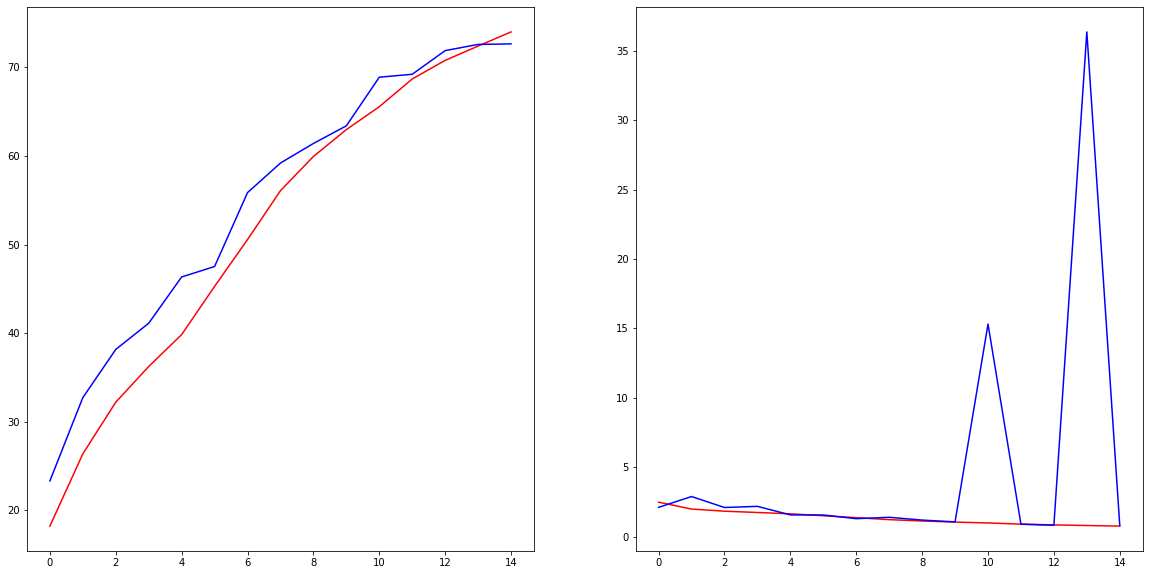

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# X coordinate for plotting
x = np.arange(15)

plt.figure(figsize=(20,10))

# Train is red, validation is blue
plt.subplot(1,2,1)
plt.plot(x,train_accs,'r')
plt.plot(x,val_accs,'b')

plt.subplot(1,2,2)
plt.plot(x,train_losses,'r')
plt.plot(x,val_losses,'b')

plt.show()

### Visualize results

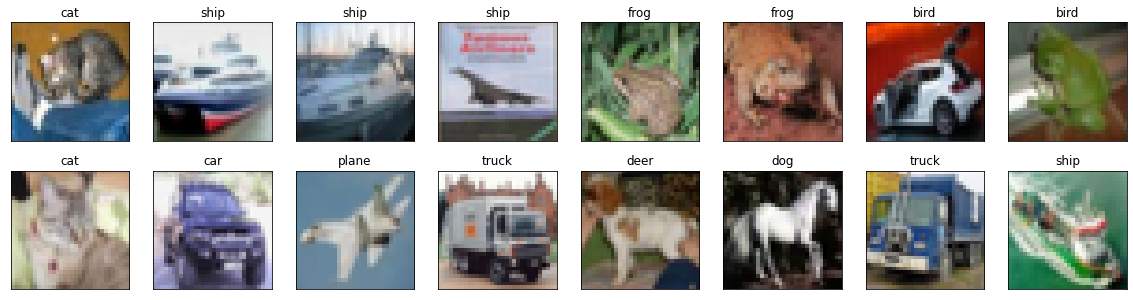

In [29]:
# Get a minibatch from the test loader and convert to cuda
inputs, labels = next(iter(testLoader))
if haveCuda:
    inputs, labels = inputs.cuda(), labels.cuda()

# forward
outputs = net(inputs)

# Get predicted class indices
_, predicted = torch.max(outputs, 1)

# Values used for normalization
mean = torch.Tensor((0.49139968, 0.48215827, 0.44653124)).unsqueeze(1).unsqueeze(1)
std = torch.Tensor((0.24703233, 0.24348505, 0.26158768)).unsqueeze(1).unsqueeze(1)

# Class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# List of subplots - we'll use 16 images
f, axarr = plt.subplots(2, 8,figsize=(20, 5))

# For every image-prediction pair
for i,(img,pred) in enumerate(zip(inputs,predicted)):
    # undo the normalization
    img_rescaled = img.cpu() * std + mean
    
    # Get predicted class name
    name = classes[pred.cpu().item()]
    
    # Permutation needed because in PyTorch the channel dimension comes first,
    # but in numpy and opencv it comes last (3x32x32) -> (32x32x3)
    axarr[i//8,i%8].imshow(img_rescaled.permute(1,2,0))
    
    # Set title to class name
    axarr[i//8,i%8].set_title(name)
    
    # Hide grid lines
    axarr[i//8,i%8].grid(False)
    
    # Hide axes ticks
    axarr[i//8,i%8].set_xticks([])
    axarr[i//8,i%8].set_yticks([])
    
    # Only do the first 16
    if i == 15:
        break